In [16]:
import pandas as pd

# Load Data
First, load the data to take a look of the original data.
We found that there is also `Cancelled` flight by column `delay_time` which was expected to be `float` or `int`.
Change `Cancelled` value to `9999` to make `delay_time` able to convert to `float`.
So for the analysis part we will analyze `on_time`, `delayed` and `cancelled` flights.

In [17]:
df = pd.read_csv("flight_delays_data.csv", parse_dates=[8])
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899114 entries, 0 to 899113
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   flight_id    899114 non-null  int64         
 1   flight_no    899114 non-null  object        
 2   Week         899114 non-null  int64         
 3   Departure    899114 non-null  object        
 4   Arrival      899114 non-null  object        
 5   Airline      897400 non-null  object        
 6   std_hour     899114 non-null  int64         
 7   delay_time   899114 non-null  object        
 8   flight_date  899114 non-null  datetime64[ns]
 9   is_claim     899114 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 68.6+ MB


In [19]:
df.delay_time.unique()

array(['0.4', '0.5', '0.0', '0.1', '0.2', '0.3', '0.9', '0.8', '-0.1',
       '1.0', '0.7', '-0.2', '2.4', '0.6', '1.2', '1.4', '1.5',
       'Cancelled', '-0.3', '2.3', '1.7', '3.7', '1.1', '3.8', '1.8',
       '5.4', '1.3', '-0.4', '2.2', '2.6', '16.2', '1.9', '1.6', '5.1',
       '4.8', '-0.7', '3.2', '2.1', '-9.3', '-8.0', '15.8', '2.0', '-7.0',
       '16.0', '3.9', '6.5', '3.5', '3.0', '-3.7', '5.3', '5.0', '2.7',
       '3.4', '5.7', '4.0', '-0.5', '2.8', '3.3', '-7.2', '-9.9', '3.6',
       '3.1', '7.5', '-8.2', '2.9', '2.5', '8.6', '6.8', '5.9', '4.7',
       '-13.9', '5.8', '12.8', '-8.1', '11.0', '-12.4', '10.6', '22.7',
       '18.3', '9.1', '-7.6', '7.8', '-6.6', '15.9', '16.1', '4.1',
       '12.0', '4.3', '4.4', '8.9', '6.0', '6.9', '7.9', '4.5', '-7.9',
       '17.0', '7.4', '7.1', '5.5', '6.4', '-7.7', '12.2', '-6.2', '11.9',
       '23.9', '4.9', '-10.8', '4.6', '9.8', '9.7', '16.8', '-1.6',
       '-12.7', '6.1', '8.7', '6.2', '12.6', '9.9', '17.6', '-7.8',
       '-

In [20]:
corr = df.corr()
corr.style.background_gradient()

ImportError: background_gradient requires matplotlib.

Then, label encode the categorical data and separate `flight_date` into three columns `flight_year`, `flight_month`, `flight_day`
I added a binary category column `label` from `is_claim`.

In [21]:
from sklearn import preprocessing

In [22]:
le = preprocessing.LabelEncoder()
df["Arrival_enc"] = le.fit_transform(df["Arrival"])
df["Airline_enc"] = le.fit_transform(df["Airline"])

In [23]:
df["flight_year"] = df["flight_date"].apply(lambda x: x.year)
df["flight_month"] = df["flight_date"].apply(lambda x: x.month)
df["flight_day"] = df["flight_date"].apply(lambda x: x.day)

df["delay_time"] = df["delay_time"].apply(lambda x: 9999 if x == "Cancelled" else float(x))

df["label"] = df["is_claim"].apply(lambda x: True if x != 0 else False)

In [24]:
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,73,110,2016,7,1,False
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,140,26,2015,4,23,False
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,94,85,2014,4,8,False


In [7]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
flight_id,1.000000,-0.000409,-0.000416,0.000650,-0.000041,0.001616,-0.001176,0.000569,-0.000473,0.000615,-0.000041
Week,-0.000409,1.000000,-0.000176,0.000285,-0.014874,-0.000057,0.001449,-0.428666,0.996447,0.096420,-0.014874
std_hour,-0.000416,-0.000176,1.000000,0.001303,-0.000481,-0.029533,0.019807,-0.003853,-0.000176,-0.000377,-0.000481
delay_time,0.000650,0.000285,0.001303,1.000000,0.801306,0.000751,0.023776,0.015390,0.001405,-0.010365,0.801306
is_claim,-0.000041,-0.014874,-0.000481,0.801306,1.000000,0.011480,0.017709,0.030985,-0.014816,0.001088,1.000000
Arrival_enc,0.001616,-0.000057,-0.029533,0.000751,0.011480,1.000000,-0.042319,-0.027319,-0.000035,0.000072,0.011480
Airline_enc,-0.001176,0.001449,0.019807,0.023776,0.017709,-0.042319,1.000000,-0.004888,0.001485,-0.000596,0.017709
flight_year,0.000569,-0.428666,-0.003853,0.015390,0.030985,-0.027319,-0.004888,1.000000,-0.431298,-0.003407,0.030985
flight_month,-0.000473,0.996447,-0.000176,0.001405,-0.014816,-0.000035,0.001485,-0.431298,1.000000,0.014613,-0.014816
flight_day,0.000615,0.096420,-0.000377,-0.010365,0.001088,0.000072,-0.000596,-0.003407,0.014613,1.000000,0.001088


# Flights EDA

Here we will focus on three columns `flight_date`, `Airline`, `Arrival`, aiming to generate some statistics feature.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
dataframe_dict = {
    "On-time": df[df.delay_time < 3],
    "Delayed": df[(df.delay_time >= 3)&(df.delay_time != 9999)],
    "Cancelled": df[df.delay_time == 9999]
}

In [68]:
def value_count_plot(item: tuple, value_columns: list, axis_index: int):
    (key, dataframe) = item
    default_col = ['delay_time']
    columns = default_col + value_columns
    df = dataframe[columns].groupby(value_columns).count()
    df.plot(ax=ax[axis_index])

    ax[axis_index].legend([key])
    for idx, row in df.reset_index().sort_values(by=default_col, ascending=False).head().iterrows():
        if len(value_columns) == 1:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns].values, y=row.loc[default_col].values), (idx+1, row.loc[default_col].values))
        else:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns[0]], y=row.loc[value_columns[1]]), (idx-1, row.loc[default_col].values))


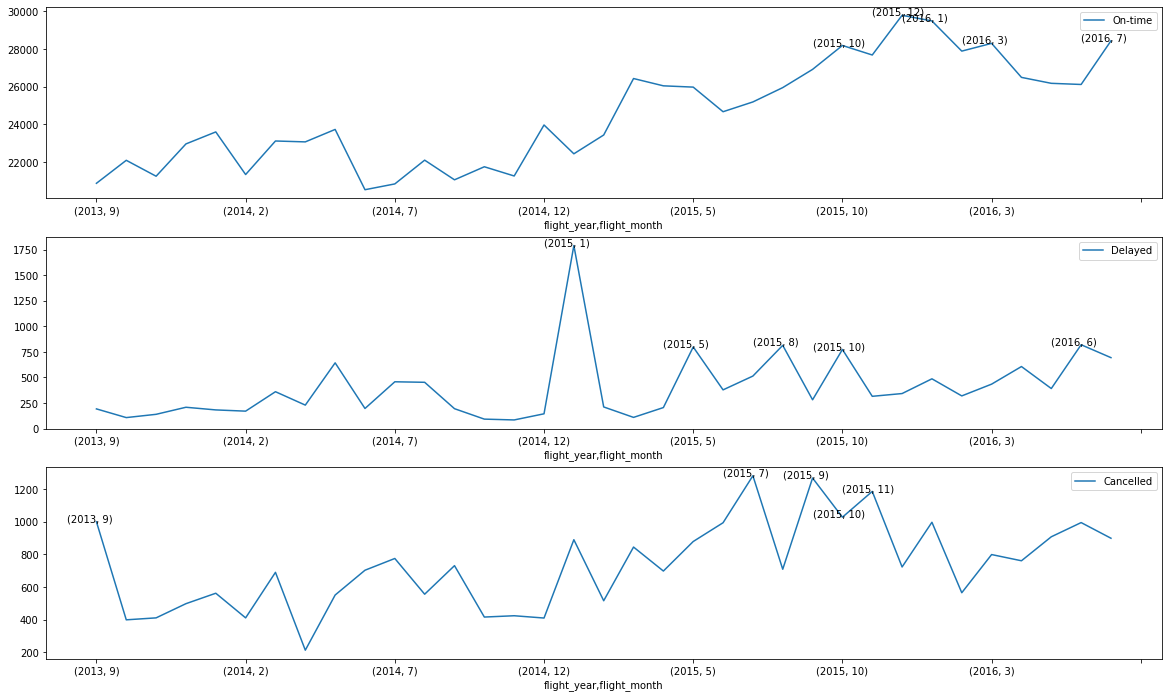

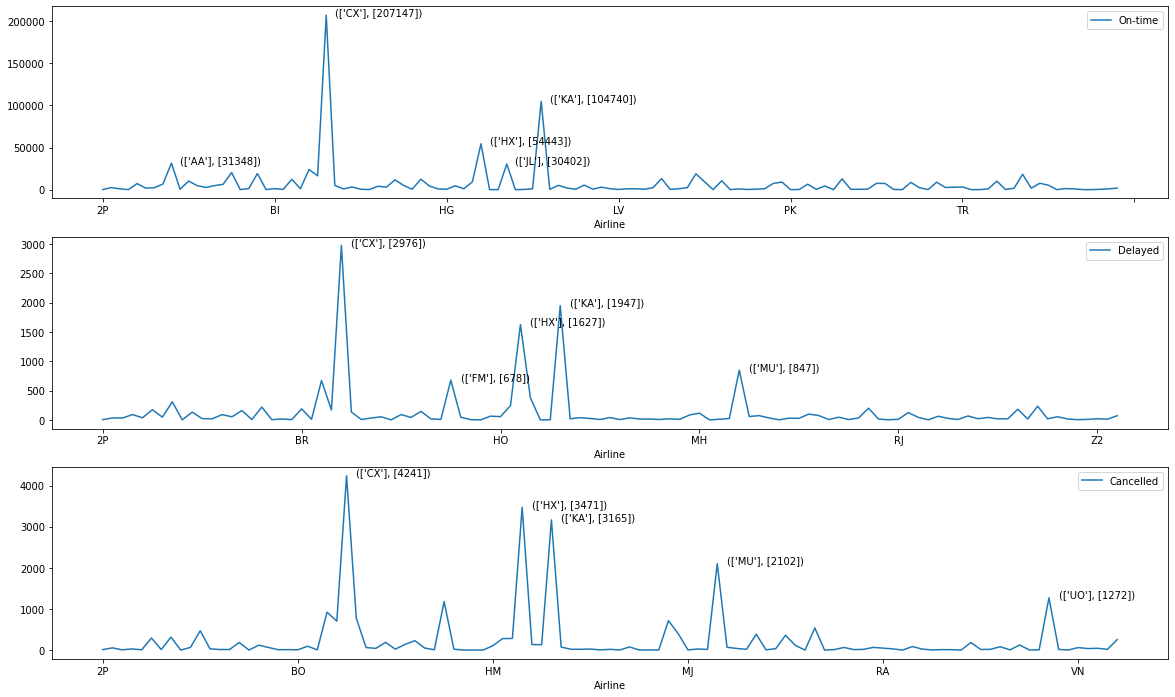

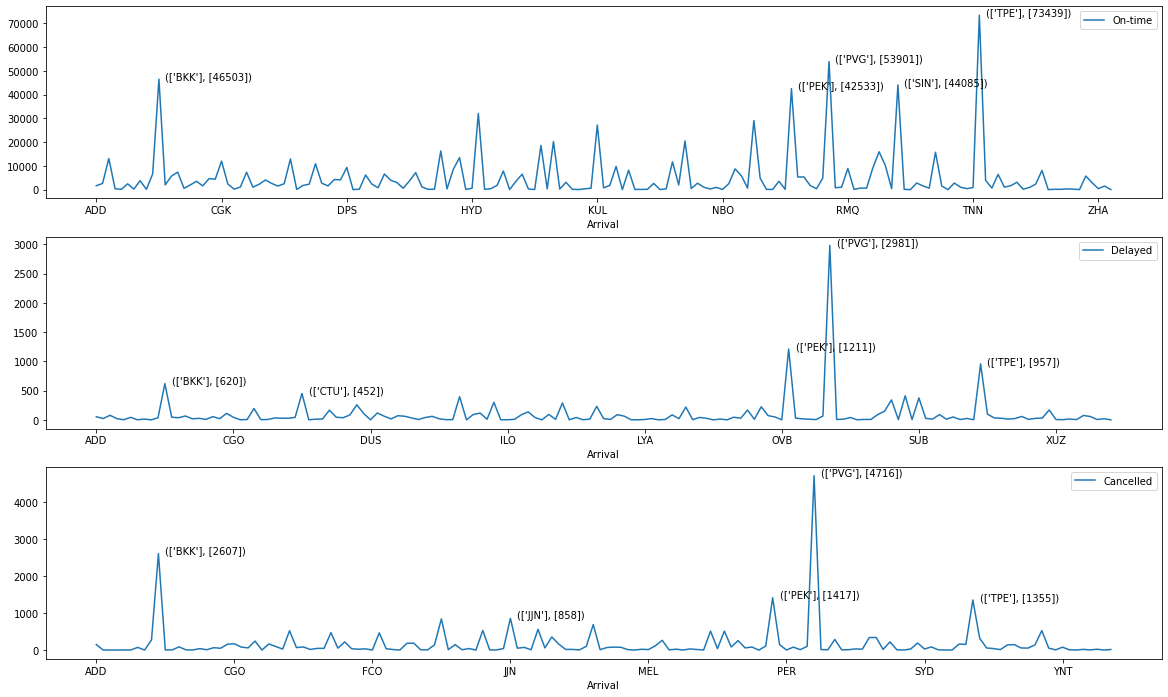

In [69]:

for col in [['flight_year', 'flight_month'], ['Airline'], ['Arrival']]:
    fig, ax=plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

    count = 0
    for item in dataframe_dict.items():
        value_count_plot(item=item, value_columns=col, axis_index=count)
        count += 1

## flight date

Above figure shows that cancelled and delayed flights happens more on second half year of 2015
and a massive delayed on Jan. 2015.
Then we make statistic columns `flight_date_count`, `flight_date_count_delayed`, `flight_date_count_cancelled`, `flight_date_delayed_ratio`

# Add statistics features to dataframe

In [70]:
dataframe_dict['Cancelled']

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
69,1582680,CX5974,19,HKG,PEK,CX,16,9999.0,2014-05-12,800,111,27,2014,5,12,True
81,1582712,MU510,20,HKG,PVG,MU,17,9999.0,2015-05-19,800,117,71,2015,5,19,True
104,1582787,CX5890,22,HKG,PVG,CX,15,9999.0,2015-05-28,800,117,27,2015,5,28,True
158,1582958,MU596,9,HKG,HGH,MU,17,9999.0,2014-03-03,800,55,71,2014,3,3,True
163,1582979,KA1385,6,HKG,BKI,KA,15,9999.0,2016-02-07,800,9,53,2016,2,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898973,2793098,KA864,37,HKG,PVG,KA,9,9999.0,2015-09-15,800,117,53,2015,9,15,True
899072,2793369,CX5864,22,HKG,PVG,CX,9,9999.0,2016-05-29,800,117,27,2016,5,29,True
899076,2793381,HX648,5,HKG,KMI,HX,11,9999.0,2016-01-30,800,76,46,2016,1,30,True
899080,2793388,CX705,2,HKG,BKK,CX,8,9999.0,2014-01-08,800,10,27,2014,1,8,True


In [ ]:
def add_statistic_features(dataframe, dataframe_dict, process_col):
    default_col = "delay_time"
    df = dataframe[process_col].groupby(process_col).count().rename(columns={default_col: f"{process_col}_count"})
    for key, val in dataframe_dict.items():
        if key in ["Cancelled", "Delayed"]:
            summary_df = dataframe_dict[key]
            df = df.join(summary_df, how='left', rsuffix=f'_{key.lower()}').fillna(0)
    df[f'{process_col}_delayed_ratio'] = (
        df.
    )
    

In [13]:
flight_date_group_count = df[['flight_date','delay_time']].groupby(['flight_date']).count().rename(columns={"delay_time": "flight_date_count"})
delayed_flight_date_group_count = delayed_flights[['flight_date','delay_time']].groupby(['flight_date']).count().rename(columns={"delay_time": "flight_date_count"})
canceled_flight_date_group_count = cancel_flights[['flight_date','delay_time']].groupby(['flight_date']).count().rename(columns={"delay_time": "flight_date_count"})

flight_date_group_count_summary = flight_date_group_count.join(
    delayed_flight_date_group_count, how='left', rsuffix='_delayed'
).join(
    canceled_flight_date_group_count, how='left', rsuffix='_canceled'
).fillna(0)
flight_date_group_count_summary["flight_date_delayed_ratio"] = (flight_date_group_count_summary.flight_date_count_delayed + flight_date_group_count_summary.flight_date_count_canceled) / flight_date_group_count_summary.flight_date_count
df = df.merge(flight_date_group_count_summary, left_on="flight_date", right_index=True)
flight_date_group_count_summary

,flight_date_count,flight_date_count_delayed,flight_date_count_canceled,flight_date_delayed_ratio
flight_date,,,,
2013-09-01,716,0.0,19.0,0.026536
2013-09-02,643,3.0,18.0,0.032659
2013-09-03,649,5.0,23.0,0.043143
2013-09-04,656,2.0,35.0,0.056402
2013-09-05,640,3.0,18.0,0.032813
...,...,...,...,...
2016-07-27,958,22.0,27.0,0.051148
2016-07-28,966,26.0,23.0,0.050725
2016-07-29,970,27.0,19.0,0.047423


## airline

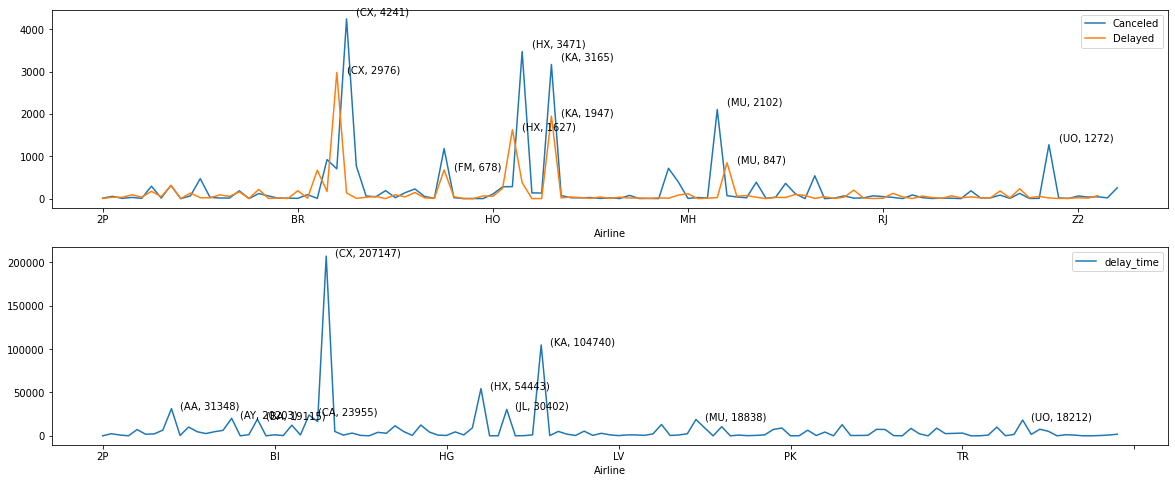

In [14]:
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

cancel_flights[['Airline','delay_time']].groupby(['Airline']).count().plot(ax=ax[0])
delayed_flights[['Airline','delay_time']].groupby(['Airline']).count().plot(ax=ax[0])
on_time_flights[['Airline','delay_time']].groupby(['Airline']).count().plot(ax=ax[1])

ax[0].legend(["Canceled", "Delayed"])
for idx, row in cancel_flights[['Airline','delay_time']].groupby(['Airline']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head().iterrows():
    ax[0].annotate(f"({row.Airline}, {row.delay_time})", (idx+1, row.delay_time+100))
for idx, row in delayed_flights[['Airline','delay_time']].groupby(['Airline']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head().iterrows():
    ax[0].annotate(f"({row.Airline}, {row.delay_time})", (idx+1, row.delay_time))
for idx, row in on_time_flights[['Airline','delay_time']].groupby(['Airline']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head(10).iterrows():
    ax[1].annotate(f"({row.Airline}, {row.delay_time})", (idx+1, row.delay_time))

In [15]:
airline_group_count = df[['Airline','delay_time']].groupby(['Airline']).count().rename(columns={"delay_time": "airline_count"})
delayed_airline_group_count = delayed_flights[['Airline','delay_time']].groupby(['Airline']).count().rename(columns={"delay_time": "airline_count"})
canceled_airline_group_count = cancel_flights[['Airline','delay_time']].groupby(['Airline']).count().rename(columns={"delay_time": "airline_count"})

airline_group_count_summary = airline_group_count.join(
    delayed_airline_group_count, how='left', rsuffix='_delayed'
).join(
    canceled_airline_group_count, how='left', rsuffix='_canceled'
).fillna(0)
airline_group_count_summary["airline_delayed_ratio"] = (airline_group_count_summary.airline_count_delayed + airline_group_count_summary.airline_count_canceled) / airline_group_count_summary.airline_count
df = df.merge(airline_group_count_summary, left_on="Airline", right_index=True)
airline_group_count_summary

,airline_count,airline_count_delayed,airline_count_canceled,airline_delayed_ratio
Airline,,,,
2P,61,4.0,12.0,0.262295
3K,2498,34.0,55.0,0.035629
3U,965,32.0,7.0,0.040415
3V,26,0.0,0.0,0.000000
5J,7323,91.0,29.0,0.016387
...,...,...,...,...
XF,28,0.0,0.0,0.000000
Y8,1,0.0,0.0,0.000000
Z2,392,20.0,19.0,0.099490


# arrival

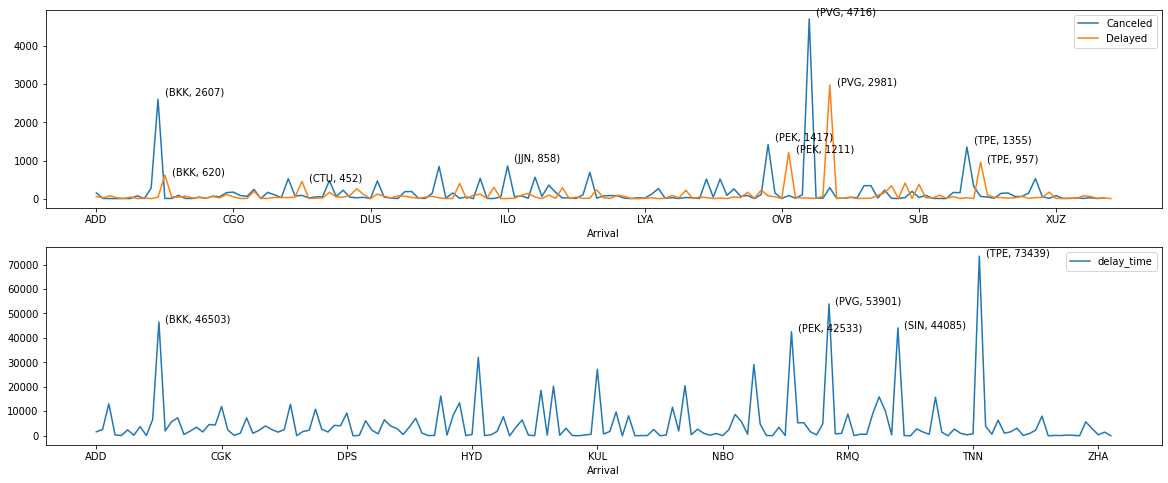

In [16]:
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

cancel_flights[['Arrival','delay_time']].groupby(['Arrival']).count().plot(ax=ax[0])
delayed_flights[['Arrival','delay_time']].groupby(['Arrival']).count().plot(ax=ax[0])
on_time_flights[['Arrival','delay_time']].groupby(['Arrival']).count().plot(ax=ax[1])

ax[0].legend(["Canceled", "Delayed"])
for idx, row in cancel_flights[['Arrival','delay_time']].groupby(['Arrival']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head().iterrows():
    ax[0].annotate(f"({row.Arrival}, {row.delay_time})", (idx+1, row.delay_time+100))
for idx, row in delayed_flights[['Arrival','delay_time']].groupby(['Arrival']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head().iterrows():
    ax[0].annotate(f"({row.Arrival}, {row.delay_time})", (idx+1, row.delay_time))
for idx, row in on_time_flights[['Arrival','delay_time']].groupby(['Arrival']).count().reset_index().sort_values(by=["delay_time"], ascending=False).head().iterrows():
    ax[1].annotate(f"({row.Arrival}, {row.delay_time})", (idx+1, row.delay_time))

In [17]:
arrival_group_count = df[['Arrival','delay_time']].groupby(['Arrival']).count().rename(columns={"delay_time": "arrival_count"})
delayed_arrival_group_count = delayed_flights[['Arrival','delay_time']].groupby(['Arrival']).count().rename(columns={"delay_time": "arrival_count"})
canceled_arrival_group_count = cancel_flights[['Arrival','delay_time']].groupby(['Arrival']).count().rename(columns={"delay_time": "arrival_count"})

arrival_group_count_summary = arrival_group_count.join(
    delayed_arrival_group_count, how='left', rsuffix='_delayed'
).join(
    canceled_arrival_group_count, how='left', rsuffix='_canceled'
).fillna(0)
arrival_group_count_summary["arrival_delayed_ratio"] = (arrival_group_count_summary.arrival_count_delayed + arrival_group_count_summary.arrival_count_canceled) / arrival_group_count_summary.arrival_count
df = df.merge(arrival_group_count_summary, left_on="Arrival", right_index=True)
arrival_group_count_summary

,arrival_count,arrival_count_delayed,arrival_count_canceled,arrival_delayed_ratio
Arrival,,,,
ADD,1841,54.0,149.0,0.110266
ADL,2632,23.0,3.0,0.009878
AKL,13158,79.0,4.0,0.006308
ALA,385,22.0,0.0,0.057143
AMM,120,3.0,1.0,0.033333
...,...,...,...,...
YVR,5806,76.0,20.0,0.016535
YYZ,3010,58.0,6.0,0.021262
ZHA,442,7.0,24.0,0.070136


In [18]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label,flight_date_count,flight_date_count_delayed,flight_date_count_canceled,flight_date_delayed_ratio,airline_count,airline_count_delayed,airline_count_canceled,airline_delayed_ratio,arrival_count,arrival_count_delayed,arrival_count_canceled,arrival_delayed_ratio
flight_id,1.000000,-0.000464,-0.000312,0.000732,0.000027,0.001506,-0.000990,0.000615,-0.000523,0.000539,0.000027,0.000005,0.000177,-0.000710,-0.000321,-0.000091,-0.000318,-0.000339,0.000778,-0.000242,0.000172,0.000010,-0.000824
Week,-0.000464,1.000000,-0.000044,0.000280,-0.014885,0.000022,0.001193,-0.428646,0.996448,0.096430,-0.014885,-0.175058,-0.099903,-0.011956,-0.076770,0.001404,-0.001725,-0.003025,-0.010851,-0.010123,-0.023693,-0.021936,-0.018528
std_hour,-0.000312,-0.000044,1.000000,0.001467,-0.000237,-0.027307,0.015700,-0.004458,-0.000042,-0.000365,-0.000237,0.000190,-0.001097,-0.000624,-0.001381,-0.099024,-0.095395,-0.089629,0.003935,-0.011915,0.003334,0.009017,-0.025570
delay_time,0.000732,0.000280,0.001467,1.000000,0.801199,0.000331,0.024137,0.015497,0.001396,-0.010313,0.801199,0.017011,0.021108,0.124219,0.082102,-0.024942,-0.007462,0.017009,0.196406,0.019212,0.072292,0.092227,0.185915
is_claim,0.000027,-0.014885,-0.000237,0.801199,1.000000,0.011010,0.018209,0.031114,-0.014830,0.001115,1.000000,0.022983,0.163859,0.125501,0.192933,-0.021949,-0.001565,0.022214,0.191202,0.031755,0.102499,0.113622,0.193426
Arrival_enc,0.001506,0.000022,-0.027307,0.000331,0.011010,1.000000,-0.036466,-0.026731,0.000043,0.000095,0.011010,-0.017722,-0.005054,-0.008007,-0.006230,0.042548,0.069425,0.084796,0.092991,0.369750,0.303862,0.127932,0.057763
Airline_enc,-0.000990,0.001193,0.015700,0.024137,0.018209,-0.036466,1.000000,-0.004919,0.001228,-0.000593,0.018209,-0.002028,-0.000928,-0.001071,-0.000981,-0.368151,-0.342894,-0.280989,0.094221,-0.030649,-0.041516,-0.014201,0.028694
flight_year,0.000615,-0.428646,-0.004458,0.015497,0.031114,-0.026731,-0.004919,1.000000,-0.431276,-0.003427,0.031114,0.825432,0.167709,0.238264,0.161867,-0.009914,-0.006592,-0.003141,0.012958,-0.023694,-0.018637,-0.010336,0.012609
flight_month,-0.000523,0.996448,-0.000042,0.001396,-0.014830,0.000043,0.001228,-0.431276,1.000000,0.014624,-0.014830,-0.179298,-0.105377,-0.003523,-0.076548,0.001312,-0.001863,-0.003196,-0.011006,-0.010307,-0.024017,-0.022304,-0.018798
flight_day,0.000539,0.096430,-0.000365,-0.010313,0.001115,0.000095,-0.000593,-0.003427,0.014624,1.000000,0.001115,0.021028,0.059422,-0.080522,0.006655,0.001141,0.001565,0.001828,0.001320,0.002541,0.003433,0.003757,0.001941


In [19]:
label = df.pop("label")
df.pop("flight_id")
df.pop("flight_no")
df.pop("Departure")
df.pop("Arrival")
df.pop("Airline")
df.pop("is_claim")
df.pop("flight_date")

0        2016-07-01
283944   2016-07-01
529472   2016-07-01
39943    2015-04-23
427293   2015-04-23
            ...    
389193   2015-04-02
124290   2014-10-22
338799   2015-07-18
583376   2014-06-18
58843    2014-01-04
Name: flight_date, Length: 897400, dtype: datetime64[ns]

# Preprocessing

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
non_std_enc_cols = ["Week", "Arrival_enc", "Airline_enc", "flight_year", "flight_month", "flight_day"]

In [22]:
scaler = StandardScaler()
df[df.columns[~df.columns.isin(non_std_enc_cols)]] = scaler.fit_transform(df[df.columns[~df.columns.isin(non_std_enc_cols)]])

In [23]:
df.head()

,Week,std_hour,delay_time,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,flight_date_count,flight_date_count_delayed,flight_date_count_canceled,flight_date_delayed_ratio,airline_count,airline_count_delayed,airline_count_canceled,airline_delayed_ratio,arrival_count,arrival_count_delayed,arrival_count_canceled,arrival_delayed_ratio
0,27,-0.727183,-0.171585,73,110,2016,7,1,0.972644,-0.064276,-0.646410,-0.452669,-0.677813,-0.791803,-0.317705,0.812598,-0.234256,-0.274999,-0.381789,-0.340555
283944,27,-0.003418,-0.171405,73,110,2016,7,1,0.972644,-0.064276,-0.646410,-0.452669,-0.677813,-0.791803,-0.317705,0.812598,-0.234256,-0.274999,-0.381789,-0.340555
529472,27,-0.727183,-0.171705,73,110,2016,7,1,0.972644,-0.064276,-0.646410,-0.452669,-0.677813,-0.791803,-0.317705,0.812598,-0.234256,-0.274999,-0.381789,-0.340555
39943,17,0.539406,-0.171825,73,110,2015,4,23,0.370260,-0.372609,-0.315624,-0.465306,-0.677813,-0.791803,-0.317705,0.812598,-0.234256,-0.274999,-0.381789,-0.340555
427293,17,-0.003418,-0.171825,73,110,2015,4,23,0.370260,-0.372609,-0.315624,-0.465306,-0.677813,-0.791803,-0.317705,0.812598,-0.234256,-0.274999,-0.381789,-0.340555


In [24]:
data = df

# Feature Selection

In [21]:
!pip install tpot mlxtend scikit-learn joblib xgboost

     |████████████████████████████████| 87 kB 3.3 MB/s             
     |████████████████████████████████| 1.3 MB 26.8 MB/s            
     |████████████████████████████████| 173.6 MB 4.5 kB/s             
     |████████████████████████████████| 160 kB 70.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=39b33720b4d157421e0e78e8446d73ce22dbbff61aef136bdf56a41bde80f2af
  Stored in directory: /home/jupyter/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit


In [25]:
from tpot import TPOTClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

/home/tim/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/tim/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
xgb = XGBClassifier(n_estimators=10,
                    max_depth=6,
                    learning_rate=0.5,
                    use_label_encoder=False,
                    n_jobs=-1,
                    verbosity=0)
len_features = len(data.columns)

X_train, _, y_train, _ = train_test_split(data,
                                          label.values,
                                          train_size=0.75,
                                          test_size=0.25,
                                          random_state=39)


In [30]:
%%time
sfs = SFS(xgb,
          k_features=(1, len_features),
          forward=True,
          # floating=True,
          verbose=1,
          cv=2, # deafault using 5, changing to 2 for less computing time
          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished
Features: 1/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:  1.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  1.7min finished
Features: 2/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:  1.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.6min finished
Features: 3/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:  1.3min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  1.4min finished
Features: 4/20[Parallel(n_jobs=-1)]: Using

CPU times: user 3.7 s, sys: 8.4 s, total: 12.1 s
Wall time: 20min 21s


In [26]:
# selected_features = list(sfs.k_feature_names_)
selected_features = ['Week', 'std_hour', 'delay_time', 'Arrival_enc', 'flight_month', 'flight_day', 'flight_date_count', 'flight_date_count_canceled', 'flight_date_delayed_ratio', 'arrival_count_canceled', 'arrival_delayed_ratio']

In [27]:
selected_data = data[selected_features]

# Hyper parameter tunning

In [28]:
import numpy as np

In [29]:
tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(3, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [-1],
        'verbosity': [0],
        # 'gpu_id': [0],
        # 'predictor': ['gpu_predictor']
    },
}

In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(selected_data.values,
                                                    label.values,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=77)
tpot_algo = TPOTClassifier(generations=3,
                           population_size=5,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           random_state=77,
                           early_stop=2,
                           verbosity=2,
                           config_dict=tpot_config)

tpot_algo.fit(X_train, y_train)
X_pre = tpot_algo.predict(X_test)
report_pre = classification_report(y_test, X_pre)

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]

/home/tim/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/tim/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/tim/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/tim/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan


Generation 1 - Current best internal CV score: 0.995771943884371

Generation 2 - Current best internal CV score: 0.995771943884371

Generation 3 - Current best internal CV score: 0.995771943884371

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=1.0, max_depth=7, min_child_weight=12, n_estimators=100, n_jobs=-1, subsample=0.3, verbosity=0)
CPU times: user 6min 25s, sys: 1.42 s, total: 6min 26s
Wall time: 20min 41s


In [31]:
model = tpot_algo.fitted_pipeline_

In [32]:
model.named_steps

{'featureunion': FeatureUnion(transformer_list=[('functiontransformer-1',
                                 FunctionTransformer(func=<function copy at 0x7fe459219790>)),
                                ('functiontransformer-2',
                                 FunctionTransformer(func=<function copy at 0x7fe459219790>))]),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=1.0, max_delta_step=0,
               max_depth=7, min_child_weight=12, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=77,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
               tree_method='exact', validate_parameters=1, verbosity=0)}

In [33]:
tpot_algo.export('tpot_digits_pipeline.py')

In [34]:
%%time
model.named_steps['xgbclassifier'].set_params(n_estimators=1000,
                                              early_stopping_rounds=10)
model.fit(X_train, y_train)

/home/tim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 24min 59s, sys: 2.2 s, total: 25min 1s
Wall time: 2min 17s


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7fe459219790>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7fe459219790>))])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree...
                               enable_categorical=False, gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=1.0, max_delta_step=0, max_depth=7,
                               min_child_weight=12, missing=nan,
                               monotone_constraints='()', n_estimato

In [35]:
X_predict = model.predict(X_test)
X_predict_pro = model.predict_proba(X_test)

In [36]:
classification_report(y_test, X_predict, output_dict=True)

{'False': {'precision': 0.9998741599008194,
  'recall': 0.9998834803035105,
  'f1-score': 0.9998788200804449,
  'support': 214556},
 'True': {'precision': 0.9974468954248366,
  'recall': 0.9972432101286502,
  'f1-score': 0.9973450423772083,
  'support': 9794},
 'accuracy': 0.9997682193002005,
 'macro avg': {'precision': 0.998660527662828,
  'recall': 0.9985633452160804,
  'f1-score': 0.9986119312288266,
  'support': 224350},
 'weighted avg': {'precision': 0.9997681976620061,
  'recall': 0.9997682193002005,
  'f1-score': 0.9997682080063398,
  'support': 224350}}

# add new column weekday 

## weekday